# **Loading Libraries**

In [1]:
from google.colab import drive
import zipfile
import os
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# **Loading Dataset**

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define paths
base_dir = '/content/drive/MyDrive'
zip_file_path = os.path.join(base_dir, 'cats_vs_dogs_small_dataset.zip')
extracted_dir_path = os.path.join(base_dir, 'cats_vs_dogs_small_dataset')

In [4]:
# Unzip dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

In [13]:
# Dataset directories for 'cat' and 'dog' folders
cat_folder_path = os.path.join(extracted_dir_path, 'cats_vs_dogs_small_dataset/cat')
dog_folder_path = os.path.join(extracted_dir_path, 'cats_vs_dogs_small_dataset/dog')

# **Splitting The Dataset**

In [6]:
# Function to split and organize dataset
def split_dataset(base_dir, cat_images, dog_images, train_samples, validation_samples, test_samples):
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')
    test_dir = os.path.join(base_dir, 'test')

    for d in [train_dir, validation_dir, test_dir]:
        shutil.rmtree(d, ignore_errors=True)
        os.makedirs(os.path.join(d, 'cat'), exist_ok=True)
        os.makedirs(os.path.join(d, 'dog'), exist_ok=True)

    # Randomly shuffle images
    random.shuffle(cat_images)
    random.shuffle(dog_images)

    # Copy images to appropriate directories
    def copy_images(src_dir, dst_dir, file_list):
        for file in file_list:
            src_path = os.path.join(src_dir, file)
            dst_path = os.path.join(dst_dir, file)
            shutil.copyfile(src_path, dst_path)

    copy_images(cat_folder_path, os.path.join(train_dir, 'cat'), cat_images[:train_samples // 2])
    copy_images(dog_folder_path, os.path.join(train_dir, 'dog'), dog_images[:train_samples // 2])

    copy_images(cat_folder_path, os.path.join(validation_dir, 'cat'),
                cat_images[train_samples // 2:train_samples // 2 + validation_samples // 2])
    copy_images(dog_folder_path, os.path.join(validation_dir, 'dog'),
                dog_images[train_samples // 2:train_samples // 2 + validation_samples // 2])

    copy_images(cat_folder_path, os.path.join(test_dir, 'cat'),
                cat_images[train_samples // 2 + validation_samples // 2:
                           train_samples // 2 + validation_samples // 2 + test_samples // 2])
    copy_images(dog_folder_path, os.path.join(test_dir, 'dog'),
                dog_images[train_samples // 2 + validation_samples // 2:
                           train_samples // 2 + validation_samples // 2 + test_samples // 2])

    return train_dir, validation_dir, test_dir

In [7]:
# Image augmentations and data generators
def create_generators(train_dir, validation_dir, test_dir, image_size, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary'
    )
    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary'
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary'
    )
    return train_generator, validation_generator, test_generator

# **Building Scartch Model**

In [17]:
# Build a convolutional model from scratch with Input layer
def build_scratch_model(image_size):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# **Building Pre Trained Models**

In [9]:
# Build a pretrained ResNet model
def build_pretrained_resnet(image_size):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# **Model Training Function**

In [23]:
# Train the model and plot results
def train_model(model, train_generator, validation_generator, epochs):
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator
    )
    return history

# **Plotting Metrics**

In [11]:
# Plot performance metrics
def plot_metrics(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [14]:
# Splitting dataset for training
test_samples = 500
validation_samples = 500
cat_images = os.listdir(cat_folder_path)
dog_images = os.listdir(dog_folder_path)

In [19]:
# Setting up parameters
batch_size = 20  # Set batch size
image_size = (150, 150)  # Set image size

# **Training from scratch with 1000 samples**

In [20]:
# Step 1: Training from scratch with 1000 samples
train_samples_step1 = 1000
train_dir, validation_dir, test_dir = split_dataset(extracted_dir_path, cat_images, dog_images, train_samples_step1, validation_samples, test_samples)
train_generator, validation_generator, test_generator = create_generators(train_dir, validation_dir, test_dir, image_size, batch_size)

Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [24]:
# Train from scratch
model_scratch_step1 = build_scratch_model(image_size)
history_scratch_step1 = train_model(model_scratch_step1, train_generator, validation_generator, epochs=10)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 277ms/step - accuracy: 0.4981 - loss: 0.9694 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 247ms/step - accuracy: 0.5045 - loss: 0.6931 - val_accuracy: 0.4940 - val_loss: 0.6931
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - accuracy: 0.4395 - loss: 0.6934 - val_accuracy: 0.5040 - val_loss: 0.6931
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 245ms/step - accuracy: 0.4739 - loss: 0.6933 - val_accuracy: 0.5440 - val_loss: 0.6930
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 0.5233 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - accuracy: 0.4963 - loss: 0.6935 - val_accuracy: 0.5420 - val_loss: 0.6903
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.5419 - loss: 0.6903 - val_accuracy: 0.5080 - val_loss: 0.6929
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 217ms/step - accuracy: 0.5820 - loss: 0.6893 - val_accu

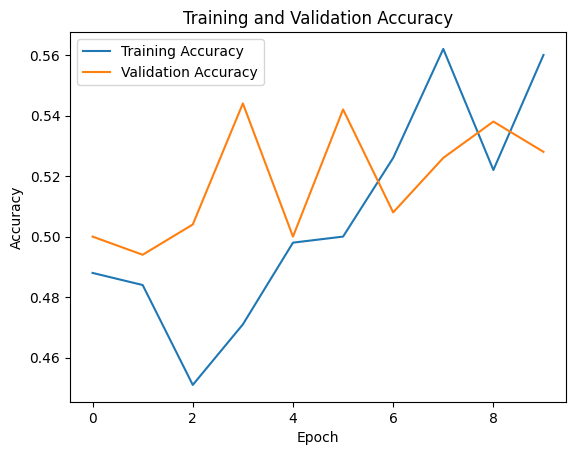

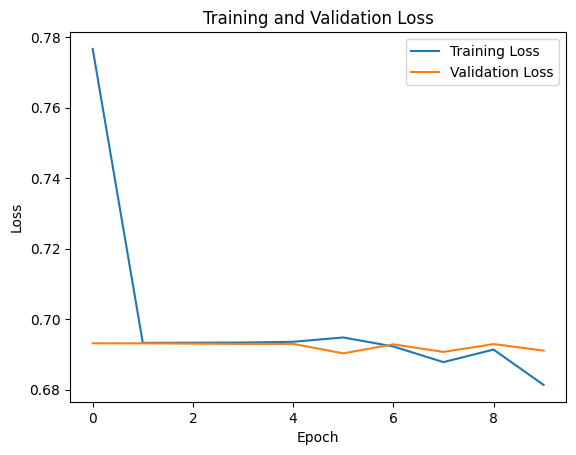

In [25]:
# Plot metrics for scratch model
plot_metrics(history_scratch_step1)

In [26]:
# Evaluate scratch model
test_loss_step1, test_accuracy_step1 = model_scratch_step1.evaluate(test_generator, steps=test_samples // batch_size)
print("Test accuracy (scratch, 1000 samples):", test_accuracy_step1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.5483 - loss: 0.6865
Test accuracy (scratch, 1000 samples): 0.5299999713897705


# **Training scratch model with 1500 samples**

In [27]:
# Step 2: Training with 1500 samples
train_samples_step2 = 1500
train_dir, validation_dir, test_dir = split_dataset(extracted_dir_path, cat_images, dog_images, train_samples_step2, validation_samples, test_samples)
train_generator, validation_generator, test_generator = create_generators(train_dir, validation_dir, test_dir, image_size, batch_size)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [28]:
# Train from scratch
model_scratch_step2 = build_scratch_model(image_size)
history_scratch_step2 = train_model(model_scratch_step2, train_generator, validation_generator, epochs=10)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 238ms/step - accuracy: 0.4882 - loss: 0.7231 - val_accuracy: 0.6500 - val_loss: 0.6646
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 234ms/step - accuracy: 0.5496 - loss: 0.6773 - val_accuracy: 0.6060 - val_loss: 0.6644
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.5567 - loss: 0.7097 - val_accuracy: 0.5920 - val_loss: 0.6775
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - accuracy: 0.5621 - loss: 0.6877 - val_accuracy: 0.5560 - val_loss: 0.6804
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - accuracy: 0.5626 - loss: 0.6814 - val_accuracy: 0.6180 - val_loss: 0.6742
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 227ms/step - accuracy: 0.6042 - loss: 0.6739 - val_accuracy: 0.6220 - val_loss: 0.6416
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.6119 - loss: 0.6677 - val_accuracy: 0.6600 - val_loss: 0.6236
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 226ms/step - accuracy: 0.6076 - loss: 0.6460 - val_accu

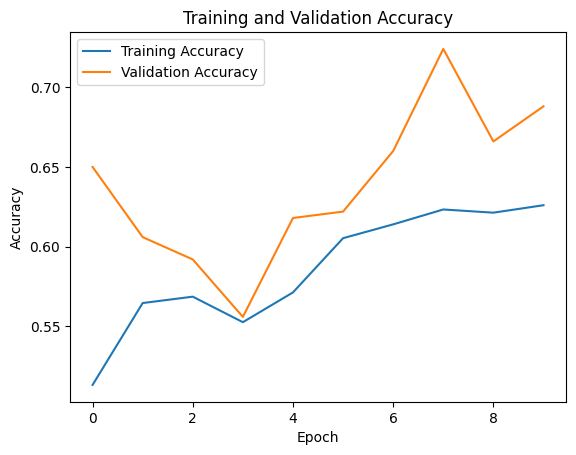

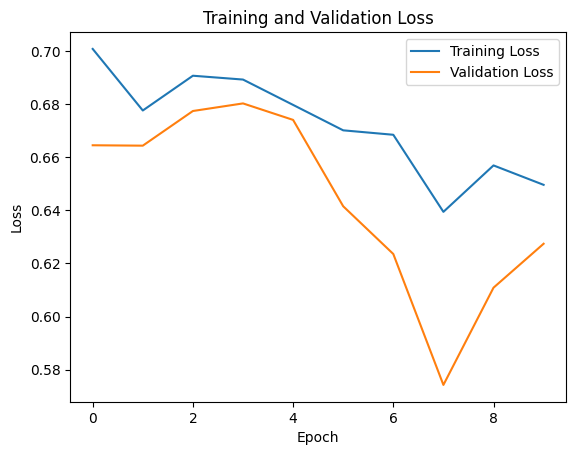

In [29]:
# Plot metrics for scratch model
plot_metrics(history_scratch_step2)

In [30]:
# Evaluate scratch model
test_loss_step2, test_accuracy_step2 = model_scratch_step2.evaluate(test_generator, steps=test_samples // batch_size)
print("Test accuracy (scratch, 1500 samples):", test_accuracy_step2)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.7237 - loss: 0.6204
Test accuracy (scratch, 1500 samples): 0.671999990940094


# **Training scartch with 2500 samples**

In [31]:
# Step 3: Training with 2500 samples
train_samples_step3 = 2500
train_dir, validation_dir, test_dir = split_dataset(extracted_dir_path, cat_images, dog_images, train_samples_step3, validation_samples, test_samples)
train_generator, validation_generator, test_generator = create_generators(train_dir, validation_dir, test_dir, image_size, batch_size)

Found 2500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [32]:
# Train from scratch
model_scratch_step3 = build_scratch_model(image_size)
history_scratch_step3 = train_model(model_scratch_step3, train_generator, validation_generator, epochs=10)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 262ms/step - accuracy: 0.4945 - loss: 0.7627 - val_accuracy: 0.5680 - val_loss: 0.6888
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 228ms/step - accuracy: 0.5510 - loss: 0.6926 - val_accuracy: 0.5640 - val_loss: 0.6854
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 233ms/step - accuracy: 0.5698 - loss: 0.6860 - val_accuracy: 0.6080 - val_loss: 0.6711
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 233ms/step - accuracy: 0.5539 - loss: 0.6877 - val_accuracy: 0.5460 - val_loss: 0.6876
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.5824 - loss: 0.6766 - val_accuracy: 0.5380 - val_loss: 0.7204
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy: 0.5941 - loss: 0.6707 - val_accuracy: 0.6560 - val_loss: 0.6512
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 225ms/step - accuracy: 0.6092 - loss: 0.6599 - val_accuracy: 0.5800 - val_loss: 0.6381
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.6378 - loss: 0

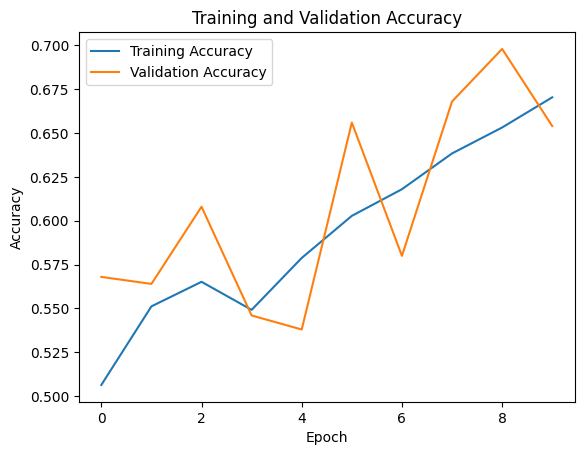

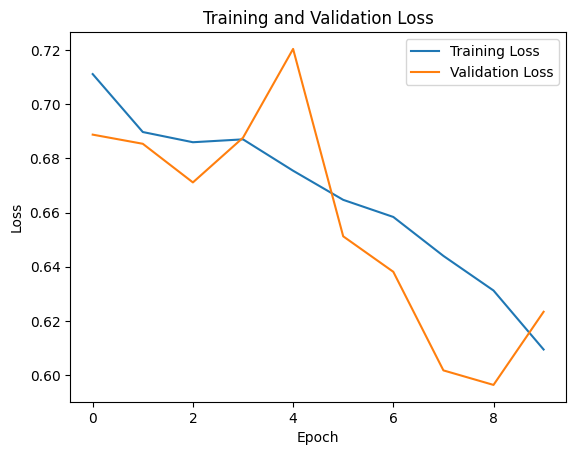

In [33]:
# Plot metrics for scratch model
plot_metrics(history_scratch_step3)

In [34]:
# Evaluate scratch model
test_loss_step3, test_accuracy_step3 = model_scratch_step3.evaluate(test_generator, steps=test_samples // batch_size)
print("Test accuracy (scratch, 2500 samples):", test_accuracy_step3)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.6439 - loss: 0.6347
Test accuracy (scratch, 2500 samples): 0.6399999856948853


# **Training Pre Trained Model**

In [37]:
# Step 4: Using a Pretrained Model

# Function to evaluate pretrained model with different training sample sizes
def evaluate_pretrained_model(train_samples, image_size, batch_size, validation_samples, test_samples):
    train_dir, validation_dir, test_dir = split_dataset(extracted_dir_path, cat_images, dog_images, train_samples, validation_samples, test_samples)
    train_generator, validation_generator, test_generator = create_generators(train_dir, validation_dir, test_dir, image_size, batch_size)

    model_resnet = build_pretrained_resnet(image_size)
    history_resnet = train_model(model_resnet, train_generator, validation_generator, epochs=10)

    # Plot metrics for ResNet model
    plot_metrics(history_resnet)

    # Evaluate pretrained ResNet model
    test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(test_generator, steps=test_samples // batch_size)
    print(f"Test accuracy (ResNet, {train_samples} samples):", test_accuracy_resnet)


Evaluating Pretrained Model:
Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 341ms/step - accuracy: 0.4969 - loss: 2.5380 - val_accuracy: 0.6000 - val_loss: 0.6637
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 256ms/step - accuracy: 0.4803 - loss: 0.7654 - val_accuracy: 0.5400 - val_loss: 0.6852
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 288ms/step - accuracy: 0.5178 - loss: 0.6971 - val_accuracy: 0.5780 - val_loss: 0.6874
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 268ms/step - accuracy: 0.5374 - loss: 0.6918 - val_accuracy: 0.5280 - val_loss: 0.6858
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 269ms/step - accuracy: 0.5244 - loss: 0.6895 - val_accuracy: 0.5160 - val_loss: 0.6898
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.5278 - loss: 0.6984 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 251ms/step - accuracy: 0.5073 

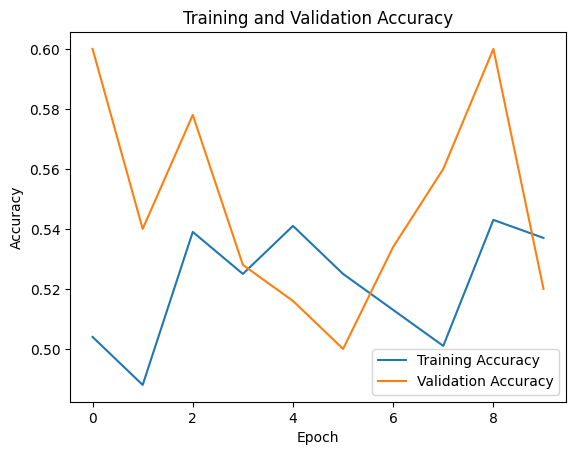

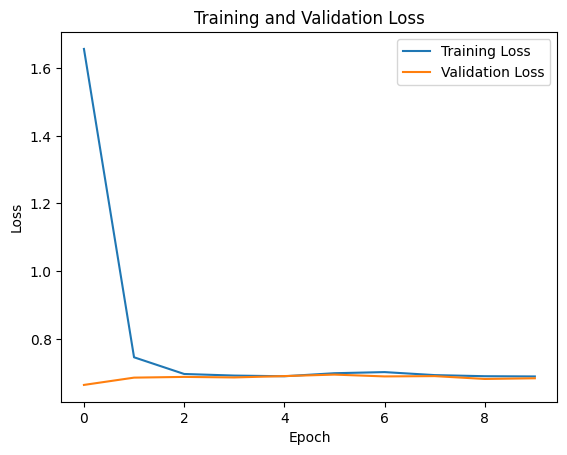

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.5531 - loss: 0.6825
Test accuracy (ResNet, 1000 samples): 0.5400000214576721


In [38]:
# Evaluate pretrained model with sample sizes 1000, 2000, and 2500
print("\nEvaluating Pretrained Model:")
evaluate_pretrained_model(1000, image_size, batch_size, validation_samples, test_samples)

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.5153 - loss: 1.6926 - val_accuracy: 0.5600 - val_loss: 0.6837
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 238ms/step - accuracy: 0.5363 - loss: 0.7121 - val_accuracy: 0.5000 - val_loss: 0.6908
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 245ms/step - accuracy: 0.5430 - loss: 0.6901 - val_accuracy: 0.5580 - val_loss: 0.6833
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 244ms/step - accuracy: 0.5581 - loss: 0.6914 - val_accuracy: 0.5000 - val_loss: 0.6967
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step - accuracy: 0.5044 - loss: 0.6951 - val_accuracy: 0.6220 - val_loss: 0.6816
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 255ms/step - accuracy: 0.5474 - loss: 0.6872 - val_accuracy: 0.5000 - val_loss: 0.7121
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 229ms/step - accuracy: 0.5048 - loss: 0.7012 -

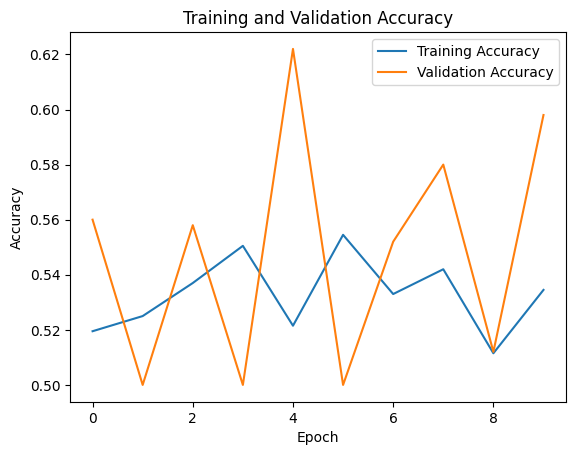

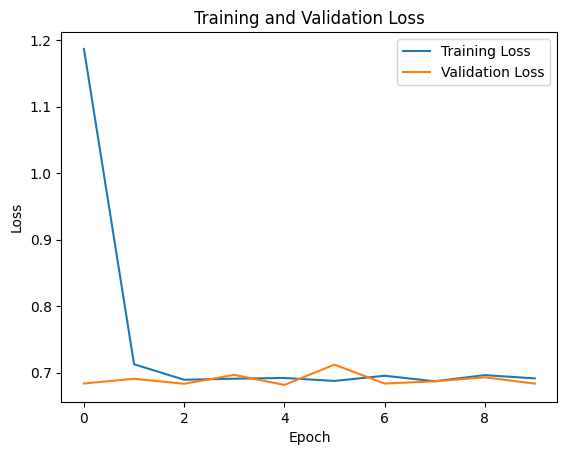

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.5487 - loss: 0.6881
Test accuracy (ResNet, 2000 samples): 0.5759999752044678


In [39]:
evaluate_pretrained_model(2000, image_size, batch_size, validation_samples, test_samples)

Found 2500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 274ms/step - accuracy: 0.4718 - loss: 1.7947 - val_accuracy: 0.5000 - val_loss: 0.6964
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 243ms/step - accuracy: 0.5183 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 238ms/step - accuracy: 0.4821 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 235ms/step - accuracy: 0.5195 - loss: 0.6926 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 261ms/step - accuracy: 0.5194 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 242ms/step - accuracy: 0.4797 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 234ms/step - accuracy: 0.4996 - loss: 0.6944 -

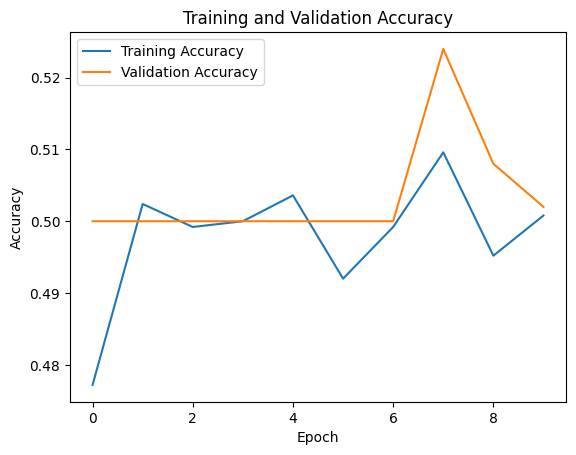

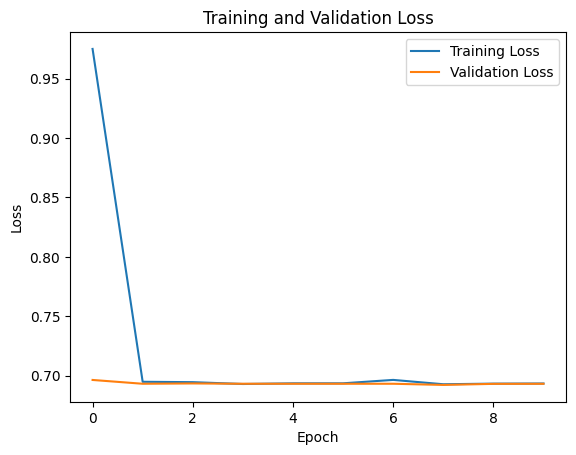

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.5174 - loss: 0.6925
Test accuracy (ResNet, 2500 samples): 0.5120000243186951


In [40]:
evaluate_pretrained_model(2500, image_size, batch_size, validation_samples, test_samples)